<a href="https://colab.research.google.com/github/ste-corizzato/NLP-Project/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Evaluation**


In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Config
from transformers import get_linear_schedule_with_warmup

import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split, RandomSampler, SequentialSampler

from google.colab import drive
import pandas as pd
import random
import os

from tqdm.auto import tqdm
import datetime
import time

In [ ]:
gdrive_dir = '/content/gdrive/'

In [ ]:
drive.mount(gdrive_dir)

Mounted at /content/gdrive/


#Funzione Infer

In [ ]:
def infer(prompt):
    input = f"<|startoftext|>Ingredients: {prompt.strip()}"
    input = tokenizer(input, return_tensors="pt")
    input_ids      = input["input_ids"]
    attention_mask = input["attention_mask"]

    output = model.generate(input_ids.to(device),
                            attention_mask=attention_mask.to(device),
                            max_new_tokens=max_length,
                            do_sample = True, top_k = 50, top_p = 0.85)
    output = tokenizer.decode(output[0], skip_special_tokens=True)
    return output

# Preparo Dati
Scelgo ricette con rating bassi e alti che condividano gli stessi ingredinti (75% min?) e calcolo la distanza fra una generata (con i medesimi ingredienti) dalle ricette buone e cattive

##Prendo i dati

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download irkaal/foodcom-recipes-and-reviews

Dataset URL: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews
License(s): CC0-1.0
 99% 718M/723M [00:09<00:00, 21.0MB/s]
100% 723M/723M [00:09<00:00, 80.1MB/s]


In [ ]:
! unzip foodcom-recipes-and-reviews.zip

Archive:  foodcom-recipes-and-reviews.zip
  inflating: recipes.csv             
  inflating: recipes.parquet         
  inflating: reviews.csv             
  inflating: reviews.parquet         


In [ ]:
df_recipes = pd.read_parquet("recipes.parquet")

In [ ]:
df_recipes_clean = df_recipes[['RecipeId','RecipeIngredientParts','AggregatedRating','ReviewCount','RecipeInstructions']].copy()

In [ ]:
df_rcp_filtered = df_recipes_clean[df_recipes_clean['ReviewCount'] > 0].copy()

In [ ]:
len(df_rcp_filtered)

275028

In [ ]:
df_low_rating = df_rcp_filtered[df_rcp_filtered['AggregatedRating'] < 2.5]
len(df_low_rating)

3802

In [ ]:
df_low_rating = df_low_rating.sort_values(by=['AggregatedRating', 'ReviewCount'], ascending=[True, False])

Ho preso solo ricette con meno di 10 voti, in teoria quelle usate ne hanno tutte almeno 10. Dovrebbero essere ricette mai viste ma con rating alto



In [ ]:
df_maybe = df_rcp_filtered[df_rcp_filtered['AggregatedRating'] == 5]
len(df_maybe)

174516

In [ ]:
df_maybe = df_maybe[df_maybe['ReviewCount'] <10]
len(df_maybe)

152737

In [ ]:
df_maybe = df_maybe.sort_values(by=['AggregatedRating', 'ReviewCount'], ascending=[False, False])
df_maybe.head()

,RecipeId,RecipeIngredientParts,AggregatedRating,ReviewCount,RecipeInstructions
138,186.0,"[flour, sugar, salt, baking soda, margarine, b...",5.0,9.0,"[Combine flour, sugar, salt, cocoa and baking ..."
160,210.0,[vanilla ice cream],5.0,9.0,"[In punch bowl, combine Hi-C Hula Punch, Sprit..."
171,221.0,"[all-purpose flour, whole wheat flour, baking ...",5.0,9.0,"[Preheat oven to 400 degrees Fahrenheit., Butt..."
213,270.0,"[pears, cinnamon sticks, allspice, cloves, sugar]",5.0,9.0,[Combine pears and apple juice in a large Dutc...
291,355.0,"[apple, flour, salt, sugar, egg, baking powder...",5.0,9.0,"[Fill a 6"" x 10"" (I use a 9"" x 13"") baking pan..."


##Creo una lista di coppie di ricette con voti bassi e alti ma stessi ingredienti

In [ ]:
df_high_rating = df_maybe[:1000]
#per non guardare 150'000 ricette seleziono le prime 1000

In [ ]:
#creo lista con id e ingredienti fra le ricette con brutti voti
bad_ingre = {}
for id_low,low in df_low_rating[:100].iterrows():
  bad_ingre[low['RecipeId']] = []
  for h in low['RecipeIngredientParts']:
    bad_ingre[low['RecipeId']].append(h)

In [ ]:
#se trovo un superiore al 70% aggiungo la ricetta
matching_recipes = {}
for key in bad_ingre:
  matching_recipes[key] = []
  for id,j in df_high_rating.iterrows():
    res = list(set(bad_ingre[key]) & set(j['RecipeIngredientParts']))
    if len(res)/len(bad_ingre[key]) > 0.75:
      #print(id,res)
      matching_recipes[key].append((j['RecipeId'],res))

In [ ]:
matching_recipes = {k: v for k, v in matching_recipes.items() if v}
len(matching_recipes)

14

In [ ]:
usable_match = {}
for k,v in matching_recipes.items():
  for j in v:
    if len(j[1]) > 2:
      usable_match[k] = v[0]
  #usable_match[k] = usable_match[k][0]

In [ ]:
for a in usable_match.values():
  print(a[0])

58129.0
8535.0
6630.0
11009.0
9962.0
53331.0
31135.0
22771.0
35317.0
40341.0
15291.0


In [ ]:
df_high_rating

,RecipeId,RecipeIngredientParts,AggregatedRating,ReviewCount,RecipeInstructions
138,186.0,"[flour, sugar, salt, baking soda, margarine, b...",5.0,9.0,"[Combine flour, sugar, salt, cocoa and baking ..."
160,210.0,[vanilla ice cream],5.0,9.0,"[In punch bowl, combine Hi-C Hula Punch, Sprit..."
171,221.0,"[all-purpose flour, whole wheat flour, baking ...",5.0,9.0,"[Preheat oven to 400 degrees Fahrenheit., Butt..."
213,270.0,"[pears, cinnamon sticks, allspice, cloves, sugar]",5.0,9.0,[Combine pears and apple juice in a large Dutc...
291,355.0,"[apple, flour, salt, sugar, egg, baking powder...",5.0,9.0,"[Fill a 6"" x 10"" (I use a 9"" x 13"") baking pan..."
...,...,...,...,...,...
87601,92829.0,"[cucumbers, bell peppers, orange, onion, sugar...",5.0,9.0,"[Place all the prepared vegetables in a bowl.,..."
87669,92897.0,"[boneless skinless chicken breasts, water, cre...",5.0,9.0,"[In a sealable bag, pour Italian dressing over..."
87702,92932.0,"[arugula, extra virgin olive oil, parmigiano-r...",5.0,9.0,"[Cut off the arugula stems., Tear the leaves i..."
87709,92939.0,"[ground chicken, ground turkey, zucchini, egg,...",5.0,9.0,[Note on cooking time: you may be able to redu...


In [ ]:
tester = {}
for k,v in usable_match.items():
  coppia = {}
  coppia['ingredienti'] = v[1]
  coppia['low'] = (df_high_rating[df_high_rating['RecipeId']==v[0]])['RecipeInstructions'].iloc[0]
  coppia['high'] = (df_low_rating[df_low_rating['RecipeId']==k])['RecipeInstructions'].iloc[0]
  tester[v[0]] = coppia

In [ ]:
usable_match

{517511.0: (58129.0,
  ['salt', 'sugar', 'water', 'butter', 'flour', 'vanilla extract']),
 1253.0: (8535.0, ['olive oil', 'basil', 'parmesan cheese', 'garlic']),
 20252.0: (6630.0, ['flour', 'nutmeg', 'butter', 'brown sugar']),
 50889.0: (11009.0, ['eggs', 'sugar', 'cream cheese', 'butter', 'vanilla']),
 121419.0: (9962.0, ['water', 'salt', 'baking powder', 'flour']),
 268943.0: (53331.0,
  ['eggs', 'sugar', 'all-purpose flour', 'butter', 'vanilla extract']),
 342075.0: (31135.0, ['sugar', 'flour', 'baking powder', 'vanilla extract']),
 407040.0: (22771.0, ['water', 'salt', 'brown rice']),
 31714.0: (35317.0, ['blueberries', 'butter', 'cream cheese']),
 76132.0: (40341.0,
  ['sugar',
   'egg',
   'powdered sugar',
   'baking powder',
   'all-purpose flour',
   'butter']),
 90587.0: (15291.0, ['sugar', 'eggs', 'unsalted butter', 'cake flour'])}

In [ ]:
tester[6630.0	]

{'ingredienti': ['flour', 'nutmeg', 'butter', 'brown sugar'],
 'low': array(['Preheat oven to 375 deg F.',
        'Put half of the apples in a greased 9"x9" pan.',
        'Blend together remaining ingredients, except juice, and crumble half the flour mixture over the apples.',
        'Cover with remaining apples and flour mixture.',
        'Pour juice over top.', 'Bake 35 minutes.',
        'Great with vanilla ice cream.'], dtype=object),
 'high': array(['Combine the flour and sugar and place into the pie shell covering the bottom.',
        'Mix cream, extract and nutmeg and pour into pie shell.',
        'Dot with butter and bake at 350 degrees for 40- 45 minutes until the filling is a custard-like consistency.'],
       dtype=object)}

In [ ]:
df_tester = pd.DataFrame.from_dict(tester, orient='index')
df_tester

,ingredienti,low,high
58129.0,"[salt, sugar, water, butter, flour, vanilla ex...","[preheat oven to 350., grease and flour a bund...","[Add 2 tablespoons of butter or oil., Melt but..."
8535.0,"[olive oil, basil, parmesan cheese, garlic]","[Everything goes into the food processor., Whi...","[Smash the garlic, the basil and the nuts with..."
6630.0,"[flour, nutmeg, butter, brown sugar]","[Preheat oven to 375 deg F., Put half of the a...",[Combine the flour and sugar and place into th...
11009.0,"[eggs, sugar, cream cheese, butter, vanilla]","[In a mixing bowl, combine the cream cheese, s...","[Crust: Mix together cookie crumbs, sugar and ..."
9962.0,"[water, salt, baking powder, flour]",[In a small bowl combine yeast and sugar in wa...,"[Mix the first three ingredients together., Th..."
53331.0,"[eggs, sugar, all-purpose flour, butter, vanil...","[Preheat oven to 350., Drain pineapple, reserv...","[Preheat oven to 375., With an electric mixer,..."
31135.0,"[sugar, flour, baking powder, vanilla extract]","[(1 cup= 2 1/2 dl)., Preheat oven to 400., Mix...","[Mix dry flour, sugar and baking powder in one..."
22771.0,"[water, salt, brown rice]","[Combine the drained beans, water, onion and g...",[Put water in a medium sauce pan that has a li...
35317.0,"[blueberries, butter, cream cheese]",[For crust: Mix together crust ingredients and...,"[Roll bread flat with rolling pin., mix the ne..."
40341.0,"[sugar, egg, powdered sugar, baking powder, al...",[Combine cranberries and 1/4 cup sugar; set as...,"[Put the butter in a bowl and add the sugar, l..."


In [ ]:
df_tester['ingredienti'] = df_tester['ingredienti'].apply(lambda x: ', '.join(x))
df_tester['low'] = df_tester['low'].apply(lambda x: ', '.join(x))
df_tester['high'] = df_tester['high'].apply(lambda x: ', '.join(x))

In [ ]:
df_tester

,ingredienti,low,high
58129.0,"salt, sugar, water, butter, flour, vanilla ext...","preheat oven to 350., grease and flour a bundt...","Add 2 tablespoons of butter or oil., Melt butt..."
8535.0,"olive oil, basil, parmesan cheese, garlic","Everything goes into the food processor., Whir...","Smash the garlic, the basil and the nuts with ..."
6630.0,"flour, nutmeg, butter, brown sugar","Preheat oven to 375 deg F., Put half of the ap...",Combine the flour and sugar and place into the...
11009.0,"eggs, sugar, cream cheese, butter, vanilla","In a mixing bowl, combine the cream cheese, su...","Crust: Mix together cookie crumbs, sugar and b..."
9962.0,"water, salt, baking powder, flour",In a small bowl combine yeast and sugar in wat...,"Mix the first three ingredients together., The..."
53331.0,"eggs, sugar, all-purpose flour, butter, vanill...","Preheat oven to 350., Drain pineapple, reservi...","Preheat oven to 375., With an electric mixer, ..."
31135.0,"sugar, flour, baking powder, vanilla extract","(1 cup= 2 1/2 dl)., Preheat oven to 400., Mix ...","Mix dry flour, sugar and baking powder in one ..."
22771.0,"water, salt, brown rice","Combine the drained beans, water, onion and ga...",Put water in a medium sauce pan that has a lid...
35317.0,"blueberries, butter, cream cheese",For crust: Mix together crust ingredients and ...,"Roll bread flat with rolling pin., mix the nex..."
40341.0,"sugar, egg, powdered sugar, baking powder, all...",Combine cranberries and 1/4 cup sugar; set asi...,"Put the butter in a bowl and add the sugar, li..."


In [ ]:
df_tester.to_csv('/content/gdrive/MyDrive/NLP/Project(P2)/df_tester.csv')

##  genero ricette con stessi ingr


In [ ]:
df_tester.head()

,ingredienti,low,high
58129.0,"salt, sugar, water, butter, flour, vanilla ext...","preheat oven to 350., grease and flour a bundt...","Add 2 tablespoons of butter or oil., Melt butt..."
8535.0,"olive oil, basil, parmesan cheese, garlic","Everything goes into the food processor., Whir...","Smash the garlic, the basil and the nuts with ..."
6630.0,"flour, nutmeg, butter, brown sugar","Preheat oven to 375 deg F., Put half of the ap...",Combine the flour and sugar and place into the...
11009.0,"eggs, sugar, cream cheese, butter, vanilla","In a mixing bowl, combine the cream cheese, su...","Crust: Mix together cookie crumbs, sugar and b..."
9962.0,"water, salt, baking powder, flour",In a small bowl combine yeast and sugar in wat...,"Mix the first three ingredients together., The..."


Carico il model

In [ ]:
model_save_path  = '/content/gdrive/My Drive/NLP/Project(P2)/model-m-10mila'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
model = GPT2LMHeadModel.from_pretrained(model_save_path)
tokenizer = GPT2TokenizerFast.from_pretrained(model_save_path)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50260, bias=False)
)

In [ ]:
max_length = 180

In [ ]:
ingredienti_list = []
for i,j in df_tester.iterrows():
  ingredienti_list.append(j['ingredienti'])

In [ ]:
gemerate = []
for a in ingredienti_list:
  ricetta = infer(a)
  gemerate.append(ricetta)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
df_tester['generate'] = gemerate

In [ ]:
df_tester.to_csv('/content/gdrive/MyDrive/NLP/Project(P2)/df_tester.csv')

#Da qua analizzo

In [ ]:
data = os.path.join(gdrive_dir, "My Drive","NLP","Project(P2)","df_tester.csv")

In [ ]:
df_tester = pd.read_csv(data)
df_tester.head()

,Unnamed: 0,ingredienti,low,high,generate
0,58129.0,"salt, sugar, water, butter, flour, vanilla ext...","preheat oven to 350., grease and flour a bundt...","Add 2 tablespoons of butter or oil., Melt butt...","Ingredients: salt, sugar, water, butter, flour..."
1,8535.0,"olive oil, basil, parmesan cheese, garlic","Everything goes into the food processor., Whir...","Smash the garlic, the basil and the nuts with ...","Ingredients: olive oil, basil, parmesan cheese..."
2,6630.0,"flour, nutmeg, butter, brown sugar","Preheat oven to 375 deg F., Put half of the ap...",Combine the flour and sugar and place into the...,"Ingredients: flour, nutmeg, butter, brown suga..."
3,11009.0,"eggs, sugar, cream cheese, butter, vanilla","In a mixing bowl, combine the cream cheese, su...","Crust: Mix together cookie crumbs, sugar and b...","Ingredients: eggs, sugar, cream cheese, butter..."
4,9962.0,"water, salt, baking powder, flour",In a small bowl combine yeast and sugar in wat...,"Mix the first three ingredients together., The...","Ingredients: water, salt, baking powder, flour..."


##Carico il modello allenato ed il modello mpnet

In [ ]:
model_save_path  = '/content/gdrive/My Drive/NLP/Project(P2)/model-m-10mila'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = GPT2LMHeadModel.from_pretrained(model_save_path)
tokenizer = GPT2TokenizerFast.from_pretrained(model_save_path)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50260, bias=False)
)

In [ ]:
from sentence_transformers import SentenceTransformer, util
#model_2 = SentenceTransformer('stsb-roberta-base')
model_2 = SentenceTransformer('all-mpnet-base-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
low_list = df_tester['low'].to_list()
high_list = df_tester['high'].to_list()
gen_list = df_tester['generate'].to_list()

In [ ]:
embeddings_low = model_2.encode(low_list, convert_to_tensor=True)
embeddings_high = model_2.encode(high_list, convert_to_tensor=True)
embeddings_gen = model_2.encode(gen_list, convert_to_tensor=True)

In [ ]:
result={}
for i in range(len(df_tester)):
  coppia = {}
  print(i)
  print("similarity between low and generated: ",util.pytorch_cos_sim(embeddings_gen[i], embeddings_low[i]).item())
  print("similarity between high and generate: ",util.pytorch_cos_sim(embeddings_gen[i], embeddings_high[i]).item())
  coppia['high'] =util.pytorch_cos_sim(embeddings_gen[i], embeddings_high[i]).item()
  coppia['low'] =util.pytorch_cos_sim(embeddings_gen[i], embeddings_low[i]).item()
  result[i] = coppia
  print('----------------------------------------------------')

0
similarity between low and generated:  0.6051331758499146
similarity between high and generate:  0.7134429216384888
----------------------------------------------------
1
similarity between low and generated:  0.6121890544891357
similarity between high and generate:  0.5880536437034607
----------------------------------------------------
2
similarity between low and generated:  0.668068528175354
similarity between high and generate:  0.7375674247741699
----------------------------------------------------
3
similarity between low and generated:  0.890755295753479
similarity between high and generate:  0.6848121881484985
----------------------------------------------------
4
similarity between low and generated:  0.7484338283538818
similarity between high and generate:  0.7566596269607544
----------------------------------------------------
5
similarity between low and generated:  0.5879764556884766
similarity between high and generate:  0.7177621722221375
-----------------------------

In [ ]:
df_result = pd.DataFrame.from_dict(result, orient='index')
df_result.head()

,high,low
0,0.713443,0.605133
1,0.588054,0.612189
2,0.737567,0.668069
3,0.684812,0.890755
4,0.756660,0.748434


In [ ]:
print(df_result['high'].mean())
print(df_result['low'].mean())

0.7339721376245673
0.670527761632746


<Axes: >

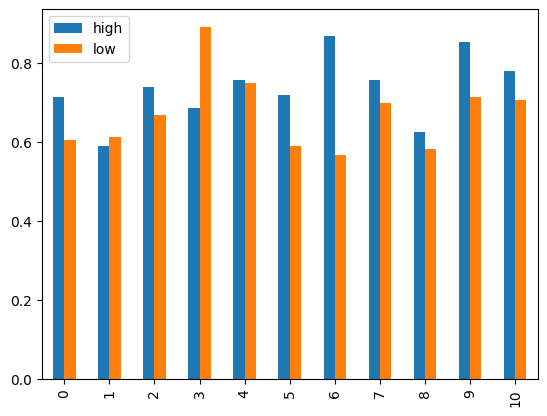

In [ ]:
df_result.plot.bar()

## BLEU

In [ ]:
df_tester.head()

,Unnamed: 0,ingredienti,low,high,generate
0,58129.0,"salt, sugar, water, butter, flour, vanilla ext...","preheat oven to 350., grease and flour a bundt...","Add 2 tablespoons of butter or oil., Melt butt...","Ingredients: salt, sugar, water, butter, flour..."
1,8535.0,"olive oil, basil, parmesan cheese, garlic","Everything goes into the food processor., Whir...","Smash the garlic, the basil and the nuts with ...","Ingredients: olive oil, basil, parmesan cheese..."
2,6630.0,"flour, nutmeg, butter, brown sugar","Preheat oven to 375 deg F., Put half of the ap...",Combine the flour and sugar and place into the...,"Ingredients: flour, nutmeg, butter, brown suga..."
3,11009.0,"eggs, sugar, cream cheese, butter, vanilla","In a mixing bowl, combine the cream cheese, su...","Crust: Mix together cookie crumbs, sugar and b...","Ingredients: eggs, sugar, cream cheese, butter..."
4,9962.0,"water, salt, baking powder, flour",In a small bowl combine yeast and sugar in wat...,"Mix the first three ingredients together., The...","Ingredients: water, salt, baking powder, flour..."


In [ ]:
import statistics
from nltk.translate.bleu_score import sentence_bleu

max_length = 180
scores=[]

for i in range(len(df_tester)):
    ingredients = df_tester.iloc[i]['ingredienti']
    reference = df_tester.iloc[i]['high']
    candidate = df_tester.iloc[i]['generate']
    scores.append(sentence_bleu(reference, candidate))

print(statistics.mean(scores))

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

8.884114819632603e-232


## Questo è il modello originale

In [ ]:
configuration_base = GPT2Config.from_pretrained('gpt2-medium')
model_base = GPT2LMHeadModel.from_pretrained('gpt2-medium', config=configuration_base)

tokenizer_base = GPT2TokenizerFast.from_pretrained('gpt2-medium')

In [ ]:
def infer_2(prompt):
    input = f"<|startoftext|>Ingredients: {prompt.strip()}"
    input = tokenizer_base(input, return_tensors="pt")
    input_ids      = input["input_ids"]
    attention_mask = input["attention_mask"]

    output = model_base.generate(input_ids,
                            attention_mask=attention_mask,
                            max_new_tokens=max_length,
                            # temperature = 0.5,
                            do_sample = True, top_k = 50, top_p = 0.85)
                            # num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
    output = tokenizer_base.decode(output[0], skip_special_tokens=True)
    return output

In [ ]:
model_base = model_base.to(device)
#combine both sampling techniques
sample_outputs = model_base.generate(input_ids.to(device),
                              do_sample = True, max_length = 180,
                              top_k = 50, top_p = 0.85,
                              num_return_sequences = 3)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
max_length = 180
scores_l=[]

for i in range(len(df_tester)):
    ingredients = df_tester.iloc[i]['ingredienti']
    reference_l = df_tester.iloc[i]['high']
    candidate_l = infer_2(ingredients)
    scores_l.append(sentence_bleu(reference_l, candidate_l))

print(statistics.mean(scores_l))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consid

8.55318482964225e-232


##METEOR

In [ ]:
import nltk

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.translate.meteor_score import meteor_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
scores_M=[]

for i in range(len(df_tester)):

    reference_l = df_tester.iloc[i]['high']
    candidate_l = df_tester.iloc[i]['generate']

    candidate_tokens = nltk.word_tokenize(candidate_l)
    reference_tokens = nltk.word_tokenize(reference_l)

    #print(reference_l)
    a = meteor_score([reference_tokens], candidate_tokens)
    scores_M.append(a)
#print(scores_M)

In [ ]:
print(statistics.mean(scores_M))

0.21202240940071515


modello originale

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
max_length = 180
scores_l_M=[]

for i in range(len(df_tester)):
    ingredients = df_tester.iloc[i]['ingredienti']
    reference_l = df_tester.iloc[i]['high']
    candidate_l = infer_2(ingredients)

    candidate_tokens = nltk.word_tokenize(candidate_l)
    reference_tokens = nltk.word_tokenize(reference_l)

    scores_l_M.append(meteor_score([reference_tokens], candidate_tokens))

print(statistics.mean(scores_l_M))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0.14919172929046481


#TEST PER GENERARE RICETTE

##Modello tuned


In [ ]:
model_save_path  = '/content/gdrive/My Drive/NLP/Project(P2)/model-m-10mila'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = GPT2LMHeadModel.from_pretrained(model_save_path)
tokenizer = GPT2TokenizerFast.from_pretrained(model_save_path)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50260, bias=False)
)

In [ ]:
data = os.path.join(gdrive_dir, "My Drive","NLP","Project(P2)","df_tester.csv")

In [ ]:
df_tester = pd.read_csv(data)
df_tester.head()

,Unnamed: 0,ingredienti,low,high,generate
0,58129.0,"salt, sugar, water, butter, flour, vanilla ext...","preheat oven to 350., grease and flour a bundt...","Add 2 tablespoons of butter or oil., Melt butt...","Ingredients: salt, sugar, water, butter, flour..."
1,8535.0,"olive oil, basil, parmesan cheese, garlic","Everything goes into the food processor., Whir...","Smash the garlic, the basil and the nuts with ...","Ingredients: olive oil, basil, parmesan cheese..."
2,6630.0,"flour, nutmeg, butter, brown sugar","Preheat oven to 375 deg F., Put half of the ap...",Combine the flour and sugar and place into the...,"Ingredients: flour, nutmeg, butter, brown suga..."
3,11009.0,"eggs, sugar, cream cheese, butter, vanilla","In a mixing bowl, combine the cream cheese, su...","Crust: Mix together cookie crumbs, sugar and b...","Ingredients: eggs, sugar, cream cheese, butter..."
4,9962.0,"water, salt, baking powder, flour",In a small bowl combine yeast and sugar in wat...,"Mix the first three ingredients together., The...","Ingredients: water, salt, baking powder, flour..."


In [ ]:
ingre_list=df_tester['ingredienti'].to_list()
ingre_list

['salt, sugar, water, butter, flour, vanilla extract',
 'olive oil, basil, parmesan cheese, garlic',
 'flour, nutmeg, butter, brown sugar',
 'eggs, sugar, cream cheese, butter, vanilla',
 'water, salt, baking powder, flour',
 'eggs, sugar, all-purpose flour, butter, vanilla extract',
 'sugar, flour, baking powder, vanilla extract',
 'water, salt, brown rice',
 'blueberries, butter, cream cheese',
 'sugar, egg, powdered sugar, baking powder, all-purpose flour, butter',
 'sugar, eggs, unsalted butter, cake flour']

In [ ]:
max_length = 180
infer('green beans, olive oil, basil, salt, pepper, cherry tomatoes')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Ingredients: green beans, olive oil, basil, salt, pepper, cherry tomatoes. Instructions: Bring a large pot of water to a boil, and cook the beans for about 10 minutes., Drain the beans and place in a blender, and blend until smooth., Drain and set aside., Heat oil in a large nonstick skillet over medium heat. Add the basil, salt and pepper., Cook, stirring occasionally, for about 2 minutes or until the oil turns a deep golden brown., Add tomatoes, reduce heat to medium low and simmer for 1 minute, or until tender., Serve with some parmesan cheese, and a glass of water.'

##modello originale

In [ ]:
configuration_base = GPT2Config.from_pretrained('gpt2-medium')
model_base = GPT2LMHeadModel.from_pretrained('gpt2-medium', config=configuration_base)
tokenizer_base = GPT2TokenizerFast.from_pretrained('gpt2-medium')

In [ ]:
input_sequence = 'Ingredients: green beans, olive oil, basil, salt, pepper, cherry tomatoes'
input_ids = tokenizer_base.encode(input_sequence, return_tensors='pt')

In [ ]:
model_base = model_base.to(device)
sample_outputs = model_base.generate(input_ids.to(device),
                              do_sample = True, max_length = 180,
                              top_k = 50, top_p = 0.85)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
print(tokenizer_base.decode(sample_outputs[0], skip_special_tokens = True))

Ingredients: green beans, olive oil, basil, salt, pepper, cherry tomatoes, lemon juice, garlic

The Recipe: Sweet and spicy, a delicious tomato stew that is very rich in flavor and has just the right amount of heat. The tomatoes add some great flavor to this dish. The vegetables will help to bring out the richness of the stew.

The Recipe

Ingredients: potatoes, green beans, olive oil, basil, salt, pepper, lemon juice, garlic

The Recipe: Rich with flavor and so delicious, this tomato stew is perfect for a dinner party. It also tastes amazing with grilled vegetables, which is always my favorite part. The vegetables also give a nice kick to this dish, so you can eat it with everything. The soup will also be great on its own, if you are looking for a vegetarian option.

The Recipe: One of
